In [3]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import pickle
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
images, target = pickle.load(open('input/dataset.pkl', 'rb'))

In [3]:
images.shape

(800, 350, 350)

In [4]:
images = images.reshape(800, -1)/255

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size=.2, stratify=target, random_state=42)

## PCA + Random Forest

In [17]:
pipe = Pipeline([('pca', PCA(n_components=.99, random_state=42)), 
                 ('estimator', RandomForestClassifier(max_depth=1, n_estimators=30, min_samples_leaf=100, n_jobs=-1, random_state=42))])

In [18]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.99, random_state=42)),
                ('estimator',
                 RandomForestClassifier(max_depth=1, min_samples_leaf=100,
                                        n_estimators=30, n_jobs=-1,
                                        random_state=42))])

In [19]:
pipe.steps[0][1].n_components_

400

In [20]:
y_pred = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

In [21]:
acc_test = accuracy_score(y_test, y_pred)
acc_train = accuracy_score(y_train, y_pred_train)
print(f'Accuracy on train set: {acc_train:.2%}\n\
Accuracy on test set: {acc_test:.2%}')

Accuracy on train set: 75.31%
Accuracy on test set: 73.12%


## CNN

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [5]:
images, target = pickle.load(open('input/dataset.pkl', 'rb'))

In [6]:
X = images.reshape(800, 350, 350, 1)/255
y = target

In [17]:
def happynet(input_shape):
    
    model = Sequential()

    # Layer C1
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    # Layer S2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer C3
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    # Layer S4
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Before going into layer C5, we flatten our units
    model.add(Flatten())
    # Layer C5
    model.add(Dense(units=120, activation='relu', kernel_regularizer=l2(0.01)))
    # Layer F6
    model.add(Dense(units=84, activation='relu'))
    # Output layer
    model.add(Dense(units=1, activation = 'sigmoid'))
    
    return model

In [18]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
             TensorBoard(log_dir='./log')]

In [19]:
model = happynet((350,350,1))

In [20]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [21]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='accuracy')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.15, stratify=y_train, random_state=42)

In [24]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=1000, callbacks=callbacks)

Epoch 1/1000
17/17 [==============================] - 11s 663ms/step - loss: 1.7311 - accuracy: 0.5441 - val_loss: 1.1945 - val_accuracy: 0.5208
Epoch 2/1000
17/17 [==============================] - 11s 648ms/step - loss: 1.0066 - accuracy: 0.6434 - val_loss: 0.8604 - val_accuracy: 0.7188
Epoch 3/1000
17/17 [==============================] - 11s 658ms/step - loss: 0.8158 - accuracy: 0.6857 - val_loss: 0.7701 - val_accuracy: 0.7188
Epoch 4/1000
17/17 [==============================] - 11s 665ms/step - loss: 0.6891 - accuracy: 0.7574 - val_loss: 0.6361 - val_accuracy: 0.7708
Epoch 5/1000
17/17 [==============================] - 11s 674ms/step - loss: 0.5880 - accuracy: 0.7941 - val_loss: 0.6862 - val_accuracy: 0.7396
Epoch 6/1000
17/17 [==============================] - 12s 679ms/step - loss: 0.4993 - accuracy: 0.8805 - val_loss: 0.7746 - val_accuracy: 0.6875
Epoch 7/1000
17/17 [==============================] - 12s 693ms/step - loss: 0.5103 - accuracy: 0.8695 - val_loss: 0.4788 - val_ac

In [25]:
loss_test, acc_test = model.evaluate(X_test, y_test)
loss_train, acc_train = model.evaluate(X_train, y_train)
print(f': Accuracy on train set: {acc_train:.2%}\n\
Accuracy on test set: {acc_test:.2%}')

17/17 [==============================] - 4s 226ms/step - loss: 0.2172 - accuracy: 0.9779
: Accuracy on train set: 97.79%
Accuracy on test set: 86.87%


## Facial landmark extraction + Random Forest

In [77]:
images, target = pickle.load(open('input/dataset.pkl', 'rb'))

In [78]:
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size=.2, stratify=target, random_state=42)

In [135]:
import face_recognition

landmarks_train = [face_recognition.face_landmarks(img) for img in X_train if face_recognition.face_landmarks(img) != []]
idx_train = [i for i in range(len(X_train)) if face_recognition.face_landmarks(X_train[i]) != []]
landmarks_test = [face_recognition.face_landmarks(img) for img in X_test if face_recognition.face_landmarks(img) != []]
idx_test = [i for i in range(len(X_test)) if face_recognition.face_landmarks(X_test[i]) != []]

In [136]:
train_data = np.array([[item for key, value in sample[0].items() for val in value for item in val] for sample in landmarks_train])

In [137]:
train_data.shape

(630, 144)

In [138]:
test_data = np.array([[item for key, value in sample[0].items() for val in value for item in val] for sample in landmarks_test])

In [139]:
test_data.shape

(159, 144)

In [151]:
fails = [i for i in np.arange(800) if i not in idx_train]

In [140]:
y_train = y_train[idx_train]
y_test = y_test[idx_test]

In [141]:
rfc = RandomForestClassifier(max_depth=2, n_estimators=30, min_samples_leaf=100, n_jobs=-1, random_state=42)

In [143]:
rfc.fit(train_data, y_train)

RandomForestClassifier(max_depth=2, min_samples_leaf=100, n_estimators=30,
                       n_jobs=-1, random_state=42)

In [144]:
y_pred = rfc.predict(test_data)

In [145]:
y_pred_train = rfc.predict(train_data)

In [146]:
acc_test = accuracy_score(y_test, y_pred)
acc_train = accuracy_score(y_train, y_pred_train)
print(f'Accuracy on train set: {acc_train:.2%}\n\
Accuracy on test set: {acc_test:.2%}')

Accuracy on train set: 91.59%
Accuracy on test set: 89.31%


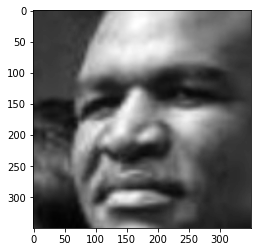

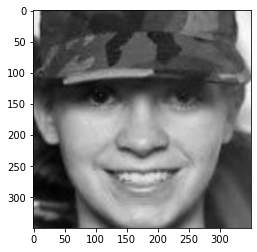

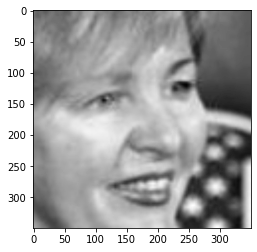

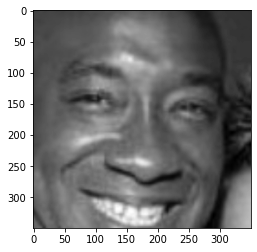

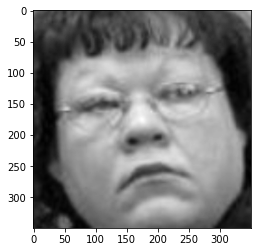

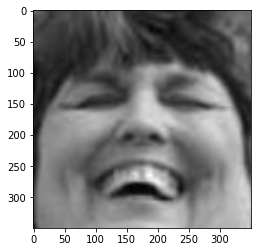

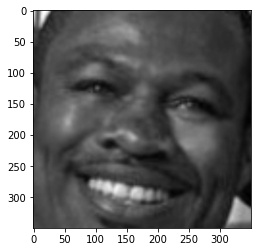

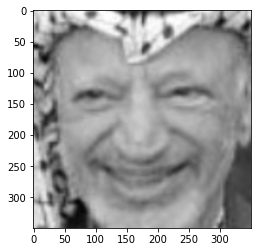

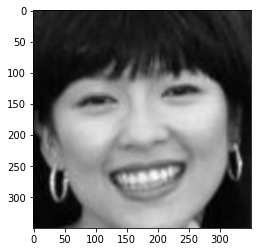

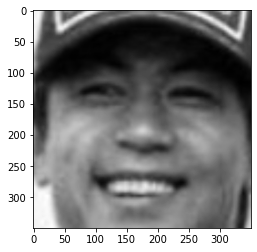

IndexError: index 640 is out of bounds for axis 0 with size 640

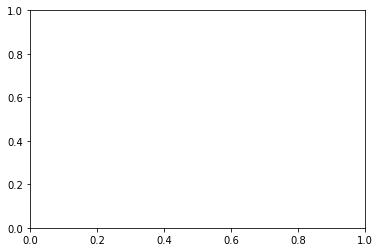

In [153]:
for i in fails:
    plt.subplot()
    plt.imshow(X_train[i], 'gray')
    plt.show()